# Transportation Infrastructure

In this notebook, we will perform a **damage and risk assessment** for transportation infrastructure, specifically focusing on **roads**. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., roads) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on transportation infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [55]:
#!pip install damagescanner==0.9b14
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [56]:
#HIDE CODE
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import matplotlib.pyplot as plt
import contextily as cx


import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
#from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [57]:
country_full_name = 'Belgium'
country_iso3 = 'BEL'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Belgium. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles with **Geopandas**, with `gpd.read_file()`, as we show in the second cell within this section.

In [58]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [59]:
%%time
features = gpd.read_file(infrastructure_path, layer="lines")
features = features[features["highway"].values != None]

CPU times: user 36.4 s, sys: 30.8 s, total: 1min 7s
Wall time: 5min 20s


> [!NOTE]  
> Depending on the size of the country, loading the critical infrastructure might take some minutes. For this example, the run time takes approximately 2 minutes, depending on the local machine.

In [60]:
sub_types = ['motorway', 'motorway_link', 'trunk', 'trunk_link',
                            'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary',
                            'tertiary_link', 'residential', 'road', 'unclassified','track']

In [61]:
features = features[features['highway'].isin(sub_types)].reset_index(drop=True)

In OpenStreetMap, these are many subtypes that can be considered. To simplify the analysis, we combine some subtypes.

In [62]:
features = features.replace({'highway' : { 'motorway_link' : 'motorway',
                         'trunk_link' : 'trunk', 
                         'primary_link' : 'primary' ,
                        'secondary_link' : 'secondary',
                         'tertiary_link' : 'tertiary', 
                         'primary_link' : 'primary',
                         'residential' : 'other' ,
                        'road' : 'other',
                         'unclassified' : 'other', 
                         'track' : 'other',                              
                              }})

Now define a new set of sub_types, to be used in the remainder of this analysis:

In [63]:
sub_types = ['motorway', 'trunk','primary', 'secondary', 'tertiary', 'other']

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a flood hazard map with a probability of ocurrence of 1 in 100 years return period to showcase the approach.

In [64]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

In [65]:
hazard_map

<xarray.Dataset> Size: 747GB
Dimensions:      (band: 1, x: 432000, y: 216000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 2MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float64 746GB ...

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

In [66]:
maxdam_dict = {'trunk':2000, 
               'motorway' : 2000,
                'primary':2000, 
                'secondary':1300, 
                'tertiary':700, 
                'other':300 }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [67]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [68]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics. The study by **Nirandjan et al. (2024)** provides us with a baseline set of fragility and vulnerability curves that one can use. In the following cell, we load that data.

In [69]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

By filtering the vulnerability curves to those relevant for river flooding, `F_Vuln_Depth` we can explore all the available options:

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [71]:
sub_types

['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'other']

In [72]:
selected_curves = dict(zip(sub_types,['F7.5','F7.5','F7.5','F7.7','F7.7','F7.9']))

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [73]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [74]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

And make sure that our damage values are in floating numbers. 

In [75]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [79]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [80]:
damage_curves = damage_curves.ffill()
#damage_curves = damage_curves.fillna(method='ffill')

Finally, make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).

In [81]:
damage_curves.index = damage_curves.index*100

### Ancilliary data for processing

In [82]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [83]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Change the column name of the object data, to ensure we can use the same functions across different infrastructure assets

In [84]:
features = features.rename(columns = {'highway' : 'object_type'})

Clip the hazard data to the country of interest. For Belgim, the `country_iso3` is **BEL**

In [85]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [86]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

In [87]:
hazard_country = hazard_country.rio.set_crs(4326)

## 4. Performing an Exposure Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. It also allows to only assess the potential exposure.

In [88]:
exposure_results = DamageScanner(hazard_country, features, damage_curves, maxdam).exposure()

convert coverage to meters: 100%|██████████| 720488/720488 [00:17<00:00, 40972.56it/s]


## 5. Performing a Vulnerability Assessment
In some cases, the cost information is unavailable, or one wants to explore only the exposure and vulnerability. To do so, we simply run the DamageScanner, by setting the maximum costs to 1.

In [89]:
vulnerability_maxdam = maxdam.copy()
vulnerability_maxdam.loc[:,'damage'] = maxdam['damage']/maxdam['damage']

In [90]:
%%time
vulnerability_results = DamageScanner(hazard_country, features, damage_curves, vulnerability_maxdam).calculate()

Calculating damage: 100%|██████████| 720488/720488 [00:24<00:00, 29436.87it/s]

CPU times: user 2min 57s, sys: 6.81 s, total: 3min 4s
Wall time: 3min 6s


## 6. Performing the Damage Assessment
In case we do have cost values, we can fully assess the damages. The function `DamageScanner` uses four main inputs to assess t

In [91]:
%%time
damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|██████████| 720488/720488 [00:24<00:00, 28832.17it/s]

CPU times: user 2min 57s, sys: 6.57 s, total: 3min 4s
Wall time: 3min 6s


## 7. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit. We show how to do this using the damage results.

In [92]:
hazard = 'river_flood'
return_period = '1_100'
damage_results.to_file(f'Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [93]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [94]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

In [95]:
admin1_damage = admin1_country.merge(damage_results[['name_right','damage']].groupby('name_right').sum(),
                                     left_on='name',
                                     right_on='name_right',
                                     how='outer')[['name','adm1_code','geometry','damage']]
admin1_damage.head()

,name,adm1_code,geometry,damage
0,Antwerp,BEL-3480,"POLYGON ((4.76418 51.49624, 4.77865 51.49536, ...",1.135872e+08
1,Brussels,BEL-3474,"POLYGON ((4.47975 50.79542, 4.39843 50.76779, ...",1.018201e+07
2,East Flanders,BEL-3478,"POLYGON ((3.3988 51.2447, 3.42194 51.23798, 3....",2.312582e+08
3,Flemish Brabant,BEL-3475,"POLYGON ((4.09974 50.70712, 4.07271 50.71291, ...",3.077080e+07
4,Hainaut,BEL-2,"MULTIPOLYGON (((2.88688 50.69665, 2.87128 50.6...",4.586031e+07


In [96]:
admin1_damage.to_file(f'Admin1_Road_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

## 8. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

Find the locations of the thirty most damaged roads.

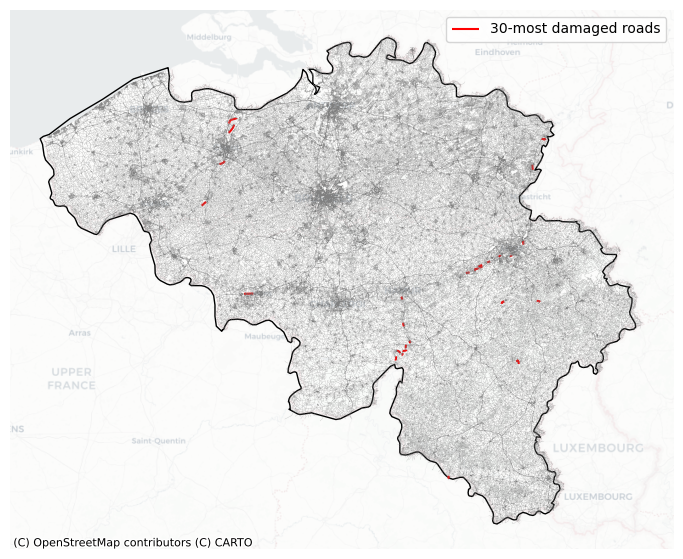

In [97]:
fig, ax = plt.subplots(1,1,figsize=(10, 7))

damage_results.to_crs(3857).sort_values('damage',ascending=False).head(30).plot(ax=ax,color='Red', label="30-most damaged roads")
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.2)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()
ax.legend()

### Plot map with damages and the distribution

To visualise the damages on the map and the histogram for all roads in Belgium, we first filter the database to exclude those transects that are not exposed to river flooding

In [98]:
damage_results = damage_results[damage_results["damage"] != 0]

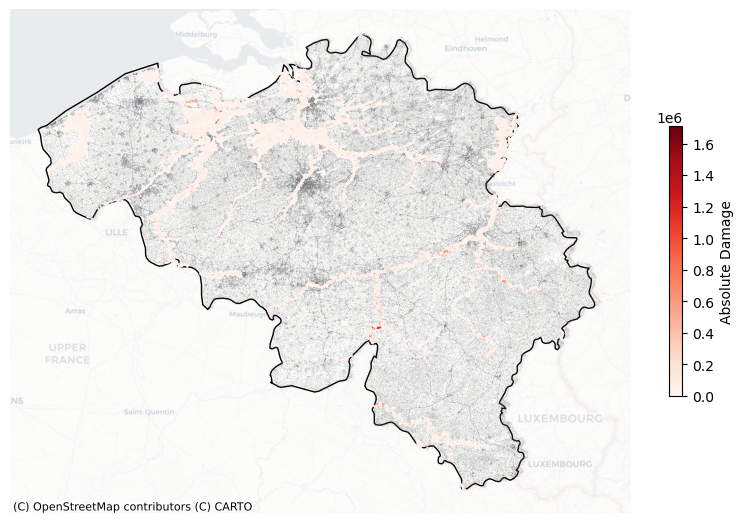

In [99]:
fig, ax = plt.subplots(1,1,figsize=(10, 7))

damage_results.to_crs(3857).plot(ax=ax,column='damage',cmap='Reds',legend=True,
                   legend_kwds={'shrink': 0.5,'label':'Absolute Damage'},zorder=5)
features.to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

In [100]:
viz(damage_results)

<Axes: xlabel='damage', ylabel='Count'>

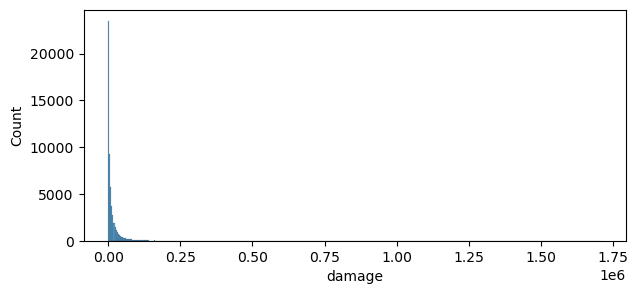

In [101]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))
sns.histplot(data=damage_results,x='damage',ax=ax)
#ax.set_ylim(0, 20000)

## 9. Performing the Risk Assessment
To do so, we need to select the return periods we want to include, and create a dictioniary as input. We will create this below.

In [102]:
return_periods = [2,5,10,50,100,200,500,1000]

hazard_dict = {}
for return_period in return_periods:
    hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/global_pc_h{return_period}glob.tif", engine="rasterio")

    hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )
    

In [103]:
risk_results = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict)

Risk Calculation: 100%|██████████| 8/8 [24:38<00:00, 184.80s/it]


 [!IMPORTANT]  
> The Risk Assessment module in `DamageScanner` is computationally intensive, especially when applied at a country level.

## 10. Visualize the Risk Assessment
To understand the relative shares of each component of the system, we create a pie chart with the percentages of risk to each component.

In [104]:
risk_per_object = risk_results[['object_type','risk']].groupby('object_type').sum()

Here we set the colors.

In [105]:
colors = ['#8c510a','#d8b365','#f6e8c3','#c7eae5','#5ab4ac','#01665e'][::-1] 

And create the figure

Text(0.5, 1.0, 'River Flood Risk for Belgium')

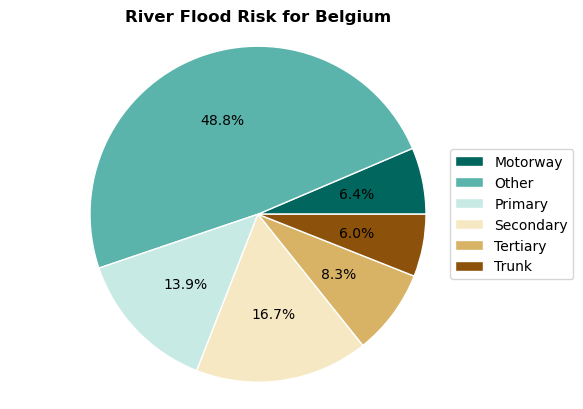

In [106]:
labels = [x.capitalize() for x in list(risk_per_object.index)]
sizes = risk_per_object.risk.values
pie = plt.pie(sizes,autopct='%1.1f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);
plt.axis('equal')
plt.legend(loc = 'right', labels=labels,bbox_to_anchor=(1.15, 0.5),)
plt.title(f'River Flood Risk for {country_full_name}',fontweight='bold')